In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from tqdm import tqdm

from statistics import mean
from wordcloud import WordCloud

import nltk

from nltk.corpus import stopwords 
STOPWORDS=set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import string
stemmer = nltk.SnowballStemmer("english")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print("\nUser defined files:\n")
        
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-07 01:38:56.711060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 01:38:56.711171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 01:38:56.858449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/transformer-pre-processed-data-2/transformer_preprocessed_data.pkl

User defined files:



In [9]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


# Check data for missing and duplicate values

In [10]:
# Check for missing Text entries

df['Text'].isnull().sum()

0

In [11]:
# Check for missing scores

df['Score'].isnull().sum()

0

In [12]:
# Keeping only the first of any duplicates

df.drop_duplicates(subset=['Text','Score'],keep='first',inplace=True)

In [13]:
df.shape

(393675, 10)

# Using a Transformer to refine dataset

The idea is to use a pre-trained transformer to omit any neutral or conflicting sentiment/score pairs reviews from the dataset 

In [100]:
# Load the pre-trained transformer and its tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

# Since the dataset is ~400k samples, processing the texts in batches can help speed up this part of pre-processing
def get_batch_sentiments(texts, batch_size=32):
    sentiments = []
    probabilities_list = []
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        
        try:
            inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
            inputs = {key: value.to(device) for key, value in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()
            
            sentiment_labels = ["negative", "neutral", "positive"]
            batch_sentiments = [sentiment_labels[np.argmax(prob)] for prob in probabilities]
            
            sentiments.extend(batch_sentiments)
            probabilities_list.extend(probabilities)
        
        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {e}")
            
            # If a batch runs into an error, run through each sentence manually and mark the erronous one as "error"
            for text in batch_texts:
                try:
                    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
                    inputs = {key: value.to(device) for key, value in inputs.items()}
                    
                    with torch.no_grad():
                        outputs = model(**inputs)
                        
                    logits = outputs.logits
                    probabilities = torch.softmax(logits, dim=-1).cpu().numpy()[0]
                    
                    sentiment = sentiment_labels[np.argmax(probabilities)]
                    sentiments.append(sentiment)
                    probabilities_list.append(probabilities)
                
                except Exception as e:
                    print(f"Error processing sentence: {text}. Error: {e}")
                    sentiments.append("error")
                    probabilities_list.append([0, 0, 0])
                    
    return sentiments, probabilities_list

texts = df['Text'].tolist()
batch_size = 32

sentiments, probabilities = get_batch_sentiments(texts, batch_size=batch_size)

df['Sentiment'] = sentiments
df['Probablities'] = probabilities

print(df)                     


100%|██████████| 12303/12303 [1:26:48<00:00,  2.36it/s]

            Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        HelpfulnessNumerator  HelpfulnessDenominato

The above function takes ~1.5 hours to run each time. To avoid having myself or my groupmates to re-run this every time, I opt to save it as a pickle file:

In [ ]:
# Save data as pickle files to avoid having to re-run pre-processing each time 
    
df_copy = df      

df_copy.to_pickle('/kaggle/working/transformer_preprocessed_data.pkl')               

In [2]:
# Verify that we can load our data back from the pickle files 

df = pd.read_pickle('/kaggle/input/transformer-pre-processed-data-2/transformer_preprocessed_data.pkl')

print(df.shape)

(393675, 12)


# Exporting updated files from directory

This section is all about exporting the pre-processed data as a zip file. Please refer to my branch (Abbas) to find 'transformer_preprocessed_data.pkl' 

In [103]:
!cd /kaggle/working  

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [104]:
!ls

file.zip  transformer_preprocessed_data.pkl


In [105]:
!zip -r file.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/transformer_preprocessed_data.pkl (deflated 64%)


In [106]:
from IPython.display import FileLink

FileLink(r'file.zip')

/kaggle/working/file.zip

# Exploratory Data Analysis

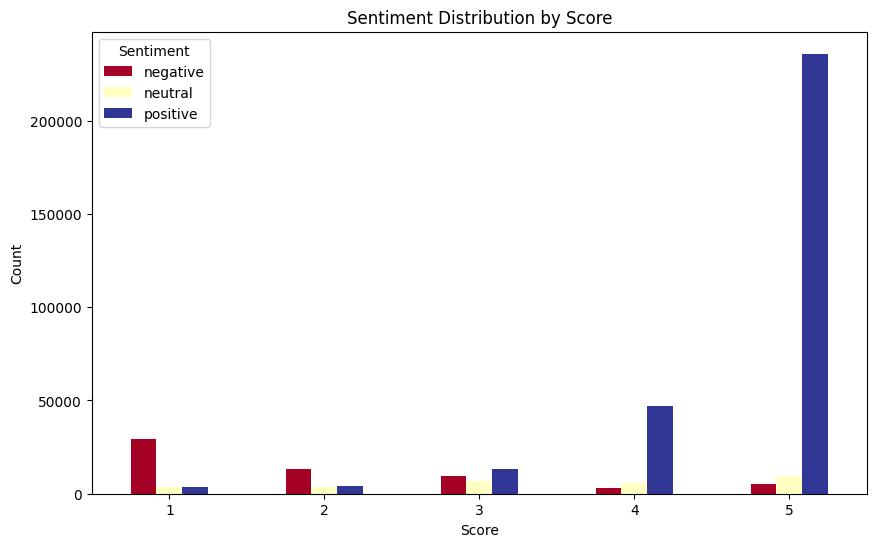

In [3]:
temp = df.groupby(['Score', 'Sentiment']).size().unstack(fill_value=0)

temp.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='RdYlBu')

plt.title('Sentiment Distribution by Score')
plt.xlabel('Score')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

We notice that there are actually very few neutral sentiment reviews across the range of scores, yet they are present in each one. Furthermore we can see that we have some positive and negative review in low and highly rated products. This could be due to sarcasm or other lingusistic styles, for example a review that was written by a non-native english speaker. To keep things as straighforward as possible, I am opting to remove neutral and conflicting sentiment-score pairs from the dataset. In doing so, I am able to define a uniform baseline for sentiments via the Roberta transformer.

In [4]:
# Drop all neutrally scored reviews

df = df[df['Sentiment']!='neutral']
df = df[df['Score']!=3]

# Drop all conflicting reviews

df = df[~((df['Score'] >= 4) & (df['Sentiment'] != 'positive'))]
df = df[~((df['Score'] <= 2) & (df['Sentiment'] != 'negative'))]

In [5]:
df.shape

(325642, 12)

Extract the probabilites of each sentiment provided by Roberta. We can use these to filter out samples by certainty in the future, if desired

In [6]:
probs = df['Probablities']
    
pos_prob = []
neutral_prob = []
neg_prob = []

for prob in probs:
    
    pos_prob.append(prob[2])
    neutral_prob.append(prob[1])
    neg_prob.append(prob[0])
    
df['Neg_Prob'] = neg_prob
df['Neutral_Prob'] = neutral_prob
df['Pos_Prob'] = pos_prob

In [7]:
temp = df.where(df['Sentiment'] == "negative").dropna()['Neg_Prob']
print(f"Mean negative prob: {sum(temp)/temp.shape[0]}")

temp = df.where(df['Sentiment'] == "positive").dropna()['Pos_Prob']
print(f"Mean positive prob: {sum(temp)/temp.shape[0]}")

Mean negative prob: 0.7813113125898866
Mean positive prob: 0.9035321660753566


We see that the model was generally more confident classifying positive reviews compared to negative reviews.

In [8]:
# Function to clean up the texts and get the stemmed version of words
# Stemming: Running -> Run, preprocessing -> process

def clean(text):
    text=str(text).lower()
     # Remove text within square brackets
    text=re.sub('\[.*?\]','',text) 
    # Remove URLs
    text=re.sub('https?://\S+|www\.\S+','',text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #  Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters with spaces
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
     # Tokenize the text and remove stopwords
    text = [word for word in text.split(' ') if word not in STOPWORDS]
    text=" ".join(text)
    # Stem the remaining words
    text = [stemmer.stem(word) for word in text.split(' ')]
    # Join the cleaned and stemmed words back into a string
    text=" ".join(text)
    return text

df['Text'] = df["Text"].apply(clean)

Here we convert the classification task from trying to predict the ratings to predicting if the reviews are positive or negative overall. We do this because reviews, which are already subjective, are trickier to learn and will not generalize as well. For example, even a simple review "Its fine." could mean different things for different people, as some may say its neutral and others may say its negative.

In [9]:
# Function for grouping scores as positive (1) or negative (0)

def group(score):
    if score > 3:
        return 1
    elif score <= 3:
        return 0

df['Score'] = df['Score'].apply(group)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df.where(df['Score'] == 0).dropna()['Text'].to_list()))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequently Occurring Words in Negative Reviews')
plt.show()

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df.where(df['Score'] == 1).dropna()['Text'].to_list()))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequently Occurring Words in Positive Reviews')
plt.show()

Looking at the wordclouds we can see that there are clear differences in the most occuring words. Some words like "good" appear in both but likely in different contexts. This is why we will need to implement n-grams or use models with the ability to make sense of this context.

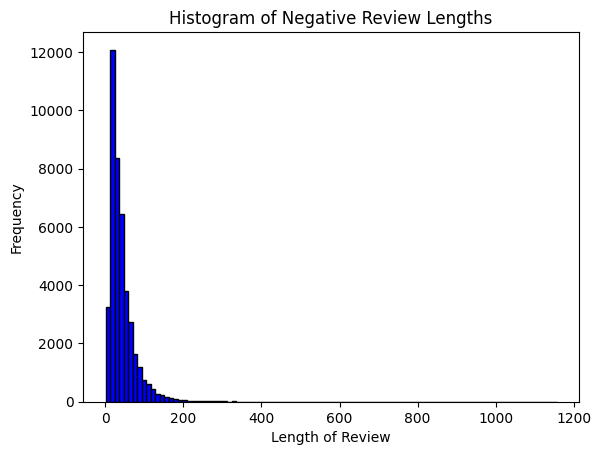

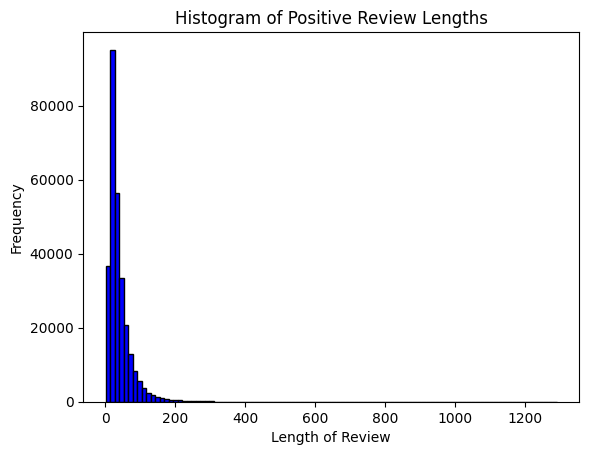

In [12]:
pos_lengths = []

for review in df.where(df['Score'] == 0).dropna()['Text']:
    pos_lengths.append(len(review.split(" ")))

plt.hist(pos_lengths, bins=100, color='blue', edgecolor='black')
plt.title('Histogram of Negative Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

neg_lengths = []

for review in df.where(df['Score'] == 1).dropna()['Text']:
    neg_lengths.append(len(review.split(" ")))

plt.hist(neg_lengths, bins=100, color='blue', edgecolor='black')
plt.title('Histogram of Positive Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

# Encode Reviews

In [13]:
# Get the number of negative reviews
limit = df.where(df['Score'] == 0).dropna().shape[0]

# Get a sample of positive review of the number of negative reviews and make a new dataframe that is of the balanced data
df = pd.concat([df.where(df['Score'] == 0).dropna(), df.where(df['Score'] == 1).dropna().sample(limit)], ignore_index =True)

In [14]:
# Observe some text samples and store the list of all reviews in 'text'

text = df['Text'].values

text

array(['product arriv label jumbo salt peanutsth peanut actual small size unsalt sure error vendor intend repres product jumbo',
       'cat happili eat felida platinum two year got new bag shape food differ tri new food first put bowl bowl sit full kitti touch food ive notic similar review relat formula chang past unfortun need find new food cat eat',
       'candi red  flavor   plan chewi   would never buy', ...,
       'one best tast protein bar market  satisfi perfect quick breakfastnot sweet fill fact gluten free ad plus',
       'tea mani year best daili kind black tea ive ever tri  tea person thing like may like vice versa ive yet meet someon like tea  mani year drank nondecaf typhoo tea recent switch decaf disappointednot typhoo tea strong  pgtip think  definit stronger lipton twin everton black tea  like good strong black tea like  decaf somewhat lighter nondecaf still stronger  dont steep long make perfect cup aromat black tea',
       'love barley soup good product keep mind

In [15]:
# Get vocab size for embedding layers later on

tokens = []

for sentence in text:
    
    tokens.extend(sentence.split())
    
word_count = {}

for token in tokens:
    
    if token in word_count:
    
        word_count[token] += 1
    
    else:
    
        word_count[token] = 1
        
vocab_size = len(word_count)

print("Vocabulary size:", vocab_size)

Vocabulary size: 84551


In [16]:
# Limit the tokenizer to only the top 5000 most frequently occuring words and encode the texts

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(text)

sequences = tokenizer.texts_to_sequences(text)

In [17]:
# Pad the sequences to ensure they are all the same lengths

padded_sequences = pad_sequences(sequences)

padded_sequences

array([[   0,    0,    0, ..., 1989,    3, 3646],
       [   0,    0,    0, ...,   17,   85,   22],
       [   0,    0,    0, ...,   11,   67,   15],
       ...,
       [   0,    0,    0, ...,  113,  139,  386],
       [   0,    0,    0, ..., 2026,  274,   13],
       [   0,    0,    0, ...,   67,  825,  277]], dtype=int32)

In [18]:
padded_sequences.shape

(85078, 933)

# Create Data Splits

In [19]:
from sklearn.model_selection import train_test_split

# Initially split into training set and other set
X_train, X_valid, y_train, y_valid = train_test_split(padded_sequences, df['Score'], test_size=0.6)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(34031, 933) (25523, 933) (25524, 933)
(34031,) (25523,) (25524,)


# Baseline Model

In [89]:
from sklearn.tree import DecisionTreeClassifier

# Default parameters
clf = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=10,
                             min_samples_split=5, min_samples_leaf=3, min_weight_fraction_leaf=0.0,  
                             max_features=None, random_state=None, max_leaf_nodes=100,
                             min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_valid, y_valid))


0.6054773588786695
0.5648630646867531


# Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

# Validate the model
y_valid_pred = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_report = classification_report(y_valid, y_valid_pred)

print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Classification Report:\n{valid_report}')

Validation Accuracy: 0.5209418955451945
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.66      0.58     12726
         1.0       0.53      0.38      0.45     12797

    accuracy                           0.52     25523
   macro avg       0.52      0.52      0.51     25523
weighted avg       0.52      0.52      0.51     25523



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Deep Learning 

In [75]:
# Adjust class weights based on the frequency of classes in y_train
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 3.8360230887030276, 1: 0.5749395292995992}

In [18]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, MultiHeadAttention, Bidirectional, BatchNormalization
import tensorflow as tf
from keras import regularizers

input_layer = Input(shape=(None,), dtype='int32')

embedding_layer = Embedding(vocab_size, 10)(input_layer)

lstm_layer = Bidirectional(LSTM(10, return_sequences=True))(embedding_layer)

# Using MultiHeadAttention layer
attention_layer = MultiHeadAttention(num_heads=10, key_dim=10)(lstm_layer, lstm_layer)

# Use the last timestep's output

dense_layer = Dense(50, activation='relu', bias_regularizer=regularizers.L2(1e-4))(attention_layer[:, -1, :])

dense_layer = Dense(1, activation='sigmoid')(dense_layer)

model = tf.keras.Model(inputs=input_layer, outputs=dense_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(X_train, np.array(y_train), 
                 batch_size=32, epochs=7, 
                 validation_data=(X_valid, np.array(y_valid)))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 10)  │    845,190 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 20)  │      1,680 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 20)  │      8,320 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 20)        │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │      1,050 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         51 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 856,291 (3.27 MB)

 Trainable params: 856,291 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 193s 176ms/step - accuracy: 0.5015 - loss: 0.6935 - val_accuracy: 0.4980 - val_loss: 0.6931
Epoch 2/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 187s 175ms/step - accuracy: 0.4928 - loss: 0.6933 - val_accuracy: 0.5021 - val_loss: 0.6931
Epoch 3/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 189s 177ms/step - accuracy: 0.5965 - loss: 0.5962 - val_accuracy: 0.9092 - val_loss: 0.2229
Epoch 4/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 189s 178ms/step - accuracy: 0.9251 - loss: 0.1906 - val_accuracy: 0.9182 - val_loss: 0.2099
Epoch 5/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 189s 178ms/step - accuracy: 0.9443 - loss: 0.1495 - val_accuracy: 0.9181 - val_loss: 0.2078
Epoch 6/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 189s 178ms/step - accuracy: 0.9538 - loss: 0.1298 - val_accuracy: 0.9162 - val_loss: 0.2288
Epoch 7/7
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 189s 178ms/step - accuracy: 0.9606 - loss: 0.1112 - val_accuracy: 0.9154 - val_loss: 0.2477


In [91]:
from sklearn.metrics import accuracy_score   
from sklearn.metrics import classification_report         
      
# Validate the model     
y_valid_pred = model.predict(X_valid)                  

798/798 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step


In [92]:
y_pred = []

for i, entry in enumerate(y_valid_pred):
    if entry[0] < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

valid_accuracy = accuracy_score(y_valid, y_pred)
valid_report = classification_report(y_valid, y_pred)

print(f'Validation Accuracy: {valid_accuracy}')      
print(f'Validation Classification Report:\n{valid_report}')    

Validation Accuracy: 0.9146652039337069
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91     12652
         1.0       0.91      0.92      0.92     12871

    accuracy                           0.91     25523
   macro avg       0.91      0.91      0.91     25523
weighted avg       0.91      0.91      0.91     25523



In [93]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

# Observe the Confusion Matrix

temp = model.predict(X_train)
    

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step


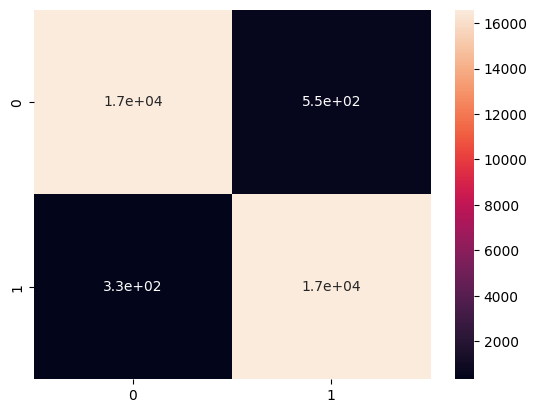

<Axes: >

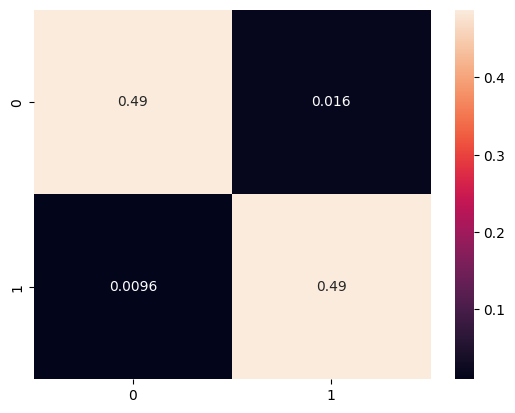

In [94]:
y_pred = []

for i, entry in enumerate(temp):
    if entry[0] < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

conf_mat = cm(y_train, y_pred)
sns.heatmap(conf_mat, annot=True)   

plt.show()

sns.heatmap(conf_mat/sum(sum(conf_mat)), annot=True)

798/798 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step


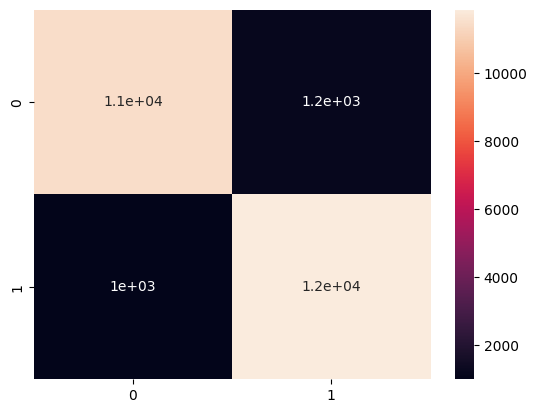

<Axes: >

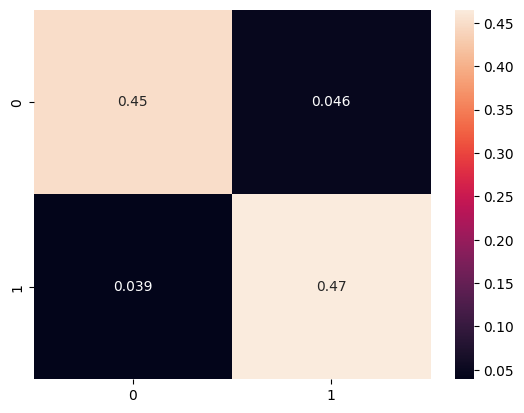

In [95]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

# Observe the Confusion Matrix

temp = model.predict(X_valid)
    

y_pred = []

for i, entry in enumerate(temp):
    if entry[0] < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

conf_mat = cm(y_valid, y_pred)
sns.heatmap(conf_mat, annot=True)   

plt.show()

sns.heatmap(conf_mat/sum(sum(conf_mat)), annot=True)

798/798 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step


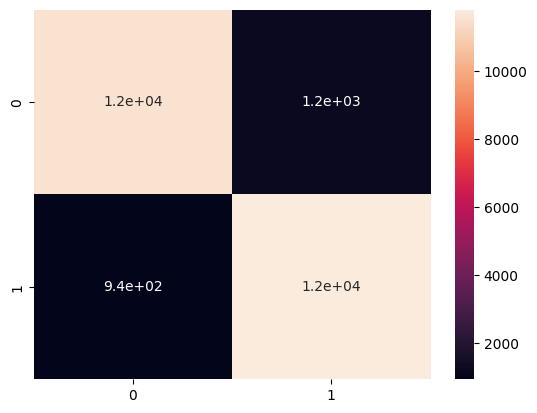

<Axes: >

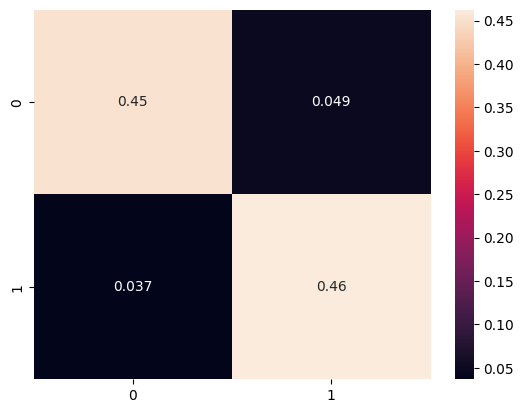

In [96]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

# Observe the Confusion Matrix

temp = model.predict(X_test)

y_pred = []

for i, entry in enumerate(temp):
    if entry[0] < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

conf_mat = cm(y_test, y_pred)
sns.heatmap(conf_mat, annot=True)   

plt.show()

sns.heatmap(conf_mat/sum(sum(conf_mat)), annot=True)

# Alt. Models

# Table of Comparisons between model architypes

Base Dense Neural Net      | accuracy: 0.5184 - loss: 0.7317 - val_accuracy: 0.5226 - val_loss: 0.7036

Dense NN + Embedding Layer | accuracy: 0.7003 - loss: 0.5436 - val_accuracy: 0.6610 - val_loss: 0.6319 

LSTM + Embedding layer + attention | accuracy: 0.9606 - loss: 0.1112 - val_accuracy: 0.9154 - val_loss: 0.2477

This is a much more summarized table of the main NN strutures I experimented with, but in general I saw that that the inclusion of LSTM and attention layers helped a lot. I assume this is because of the added context the models have the ability to work with.